# Projet de Deep Learning : Prédiction de Séries Temporelles
---

## Projet 6 : Prédiction de Série Temporelle Financière

Dans ce projet, nous analysons une série temporelle financière donnée et construisons une base de données pour entraîner un modèle de deep learning capable de prédire le rendement futur $R_{t+1}$.

---

### Description du Problème

Nous considérons une série temporelle financière $S_t$ de longueur totale $N$. Les données sont divisées en deux ensembles :
- **Entraînement** : $N_t = 0.8 \times N$
- **Validation** : $N_v = 0.2 \times N$

**Source des données** :
- À télécharger depuis [ce fichier CSV](https://turinici.com/wp-content/uploads/cours/common/close_cac40_historical.csv)
- Exemple : $N = 255 \times 10$ (10 années de données journalières)

---

### Calculs à effectuer

Pour chaque point $t$ de la série, nous calculons les éléments suivants :

1. **Rendements** :
   - $R_t = \log\left(\frac{S_t}{S_{t-1}}\right)$

2. **Moyennes glissantes des rendements** ($K$) :
   - $K = 5$ (1 semaine, 1W)
   - $K = 25$ (1 mois, 1M)
   - $K = 3 \times 25$ (3 mois, 3M)
   - $K = 6 \times 25$ (6 mois, 6M)
   - $K = 255$ (1 an, 1Y)
   - $K = 3 \times 255$ (3 ans, 3Y)

3. **Volatilité annualisée des $K$ derniers rendements**.

4. **Autres indicateurs** :
   - Prix actuel $S_t$
   - Moyenne exponentielle (EMA) des $K$ derniers prix, normalisée par $S_t$.

5. **Fenêtre glissante** :
   - Une fenêtre de longueur $n$ contenant les prix $S_{t-n}, \dots, S_t$.
   - Exemple : $n = 3 \times 25$ (3 mois).

**Remarque** : Lorsque les données historiques ne permettent pas de calculer une moyenne sur la période complète $K$, utiliser la période la plus longue disponible (éviter les valeurs `NaN`).

---

### Objectif

La base de données finale contient les caractéristiques suivantes pour chaque point :
- $N-1$ points au total
- 15 caractéristiques calculées (rendements et volatilités)
- 1 prix actuel $S_t$
- 7 EMA des derniers prix ($K$)
- $n$ prix de la fenêtre glissante

**Rendement cible** : $R_{t+1}$


In [34]:
# 0) Importation des bibliothèques et configuration

# Commandes pip install (à exécuter une seule fois avant le premier lancement du script) :

'''%pip install numpy pandas matplotlib
%pip install pandas-ta
%pip install plotly
%pip install scikit-learn
%pip install tensorflow
%pip install keras '''


# Bibliothèques standards
import numpy as np
import pandas as pd
import pandas_ta as ta

# Visualisation
import matplotlib.pyplot as plt
import plotly.graph_objects as go  

# Prétraitement et modèles de machine learning (Sklearn)
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import gaussian_kde


# Deep Learning avec TensorFlow/Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models, Model

# Système d'exploitation 
import os

# Fixation du seed pour garantir la reproductibilité
SEED = 123
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Confirmation que tout est prêt
print("Bibliothèques chargées et graine aléatoire fixée.")



Bibliothèques chargées et graine aléatoire fixée.


## Étape 1 : Lecture et Prétraitement des Données

#### 1.1. Chargement des Données
Lecture des données depuis l'URL, sélection des colonnes nécessaires et renommage.

#### 1.2. Conversion des Données
Conversion de la colonne `Date` en format datetime et définition comme index.

#### 1.3. Nettoyage des Données
- Suppression des valeurs manquantes.
- Tri des données par date.

#### 1.4. Résumé des Données
- Aperçu des premières lignes après nettoyage.
- Dimensions des données après traitement.


In [2]:
# URL des données
url = "https://turinici.com/wp-content/uploads/cours/common/close_cac40_historical.csv"

# Lecture du fichier CSV en ne chargeant que la colonne 'BNP.PA'
df_raw = pd.read_csv(url, sep=";", usecols=["Date", "BNP.PA"])

# Renommage des colonnes 
df_raw.rename(columns={"BNP.PA": "Price"}, inplace=True)

# Conversion de la colonne 'Date' en format datetime 
df_raw['Date'] = pd.to_datetime(df_raw['Date'])

# Définir la colonne 'Date' comme index
df_raw.set_index("Date", inplace=True)

print("\nAperçu des premières lignes :")
display(df_raw.head())
print("\nDimensions initiales :", df_raw.shape)

df_raw.dropna(subset=["Price"], inplace=True)

# Tri par index (date) pour s'assurer de l'ordre chronologique
df_raw.sort_index(inplace=True)

print("\nAperçu après nettoyage :")
display(df_raw.head())
print("\nDimensions après nettoyage :", df_raw.shape)




Aperçu des premières lignes :


,Price
Date,
2000-01-03,16.165972
2000-01-04,15.711578
2000-01-05,15.379528
2000-01-06,14.855226
2000-01-07,15.047465



Dimensions initiales : (8605, 1)

Aperçu après nettoyage :


,Price
Date,
1993-10-18,4.227787
1993-10-19,4.120383
1993-10-20,4.149676
1993-10-21,4.218023
1993-10-22,4.315662



Dimensions après nettoyage : (7339, 1)


## Étape 2 : Calcul des Caractéristiques et Préparation des Données

#### 2.1. Calcul du Rendement Logarithmique
- Calcul des rendements log : $ R_t = \log\left(\frac{X_t}{X_{t-1}}\right) $
- Suppression des valeurs manquantes.

#### 2.2. Moyennes Mobiles et Volatilités Annualisées
- Calcul des moyennes mobiles des rendements sur des horizons $ K $ : (1 semaine, 1 mois, 3 mois, 6 mois, 1 an, 3 ans).
- Calcul des volatilités annualisées pour les mêmes horizons.

#### 2.3. Moyennes Mobiles Exponentielles (EMA) / Prix
- Ratio entre l'EMA (Exponentially Moving Average) et le prix actuel pour chaque horizon **K**.

#### 2.4. Fenêtre Glissante
- Création de variables décalées (lags) sur une fenêtre glissante de longueur $ (n = 3 \times 25) $ jours.

#### 2.5. Cible : Rendement Futur
- Définition de la cible :  $ R_{t+1} $ , le rendement futur.

#### 2.6. Préparation des Features et de la Cible
- Séparation des données en :
  - $ Features (X) $ : Toutes les colonnes sauf `Price`, `Return`, et `FutureReturn`.
  - $ Cible (y) $ : Colonne `FutureReturn`.

#### 2.7. Normalisation des Features
- Standardisation des données (z-score) avec `StandardScaler` pour faciliter l'entraînement des modèles.


In [43]:
df = df_raw.copy()

# 2.1 Calcul du rendement log
df["Return"] = np.log(df["Price"] / df["Price"].shift(1))
df = df.dropna()  

df = df.loc['2000-01-01':]
df = df[df['Return']!=0]

# 2.2 Définition des horizons K
K_list = [5, 25, 75, 150, 252, 3*252]  # 1W, 1M, 3M, 6M, 1Y, 3Y
K_list = [K for K in K_list if K < len(df)]  

# Calcul des moyennes mobiles et volatilités annualisées
for K in K_list:
    df[f"meanRet_{K}"] = df["Return"].rolling(K).mean()
    df[f"meanRet_{K}"] = df[f"meanRet_{K}"].bfill()  

    df[f"vol_{K}"] = df["Return"].rolling(K).std() * np.sqrt(252)
    df[f"vol_{K}"] = df[f"vol_{K}"].bfill()  

# 2.4 EMA(K) / Price
for K in K_list:
    ema_series = df["Price"].ewm(span=K, adjust=False).mean()
    df[f"emaRatio_{K}"] = ema_series / df["Price"]
    df[f"emaRatio_{K}"] = df[f"emaRatio_{K}"].bfill()  

# 2.5 Fenêtre glissante
n = 25 * 3
for i in range(n):
    df[f"Price_lag_{i+1}"] = df["Price"].shift(i+1)

df = df.dropna()  

# 2.6 Cible = Rendement futur R_{t+1}
df["FutureReturn"] = df["Return"].shift(-1)
df = df.dropna()  

print(f"\nDimensions après feature engineering : {df.shape}")

# 2.7 Sélection des features (X) et de la cible (y)
exclude_cols = ["Price", "Return", "FutureReturn"]
feature_cols = [c for c in df.columns if c not in exclude_cols]
X = df[feature_cols].values
y = df["FutureReturn"].values

# 2.8 Normalisation (StandardScaler)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Feature scaling terminé.")


Dimensions après feature engineering : (5520, 96)
Feature scaling terminé.


### Étape 3 : Visualisation des Données

#### 3.1. Prix et Moyennes Mobiles Exponentielles (EMA)
- Le premier sous-graphe affiche l'évolution du prix de l'action $S_t$ ainsi que les moyennes mobiles exponentielles (EMA) calculées sur 75, 150 et 252 jours.
- La formule pour l'EMA est donnée par :
  $$
  \text{EMA}_t = \alpha \times S_t + (1 - \alpha) \times \text{EMA}_{t-1}
  $$
  où $\alpha = \frac{2}{K+1}$, $K$ étant la période de l'EMA.

#### 3.2. Volatilité Annualisée
- Le deuxième sous-graphe représente les volatilités annualisées pour les horizons de 75, 150 et 252 jours, permettant d'observer les variations du risque au fil du temps.
- La volatilité annualisée est calculée comme :
  $$
  \sigma_{\text{annuelle}} = \sigma_{\text{quotidienne}} \times \sqrt{T}
  $$
  où $T$ est le nombre de jours de l'année (généralement 252 jours pour les marchés financiers) et $\sigma_{\text{quotidienne}}$ est l'écart type des rendements sur l'horizon choisi.

#### 3.3. Distribution des Rendements Logarithmiques
- Le troisième sous-graphe illustre la distribution des rendements logarithmiques ($R_t$) sous forme d'histogramme. Une ligne verticale rouge indique la moyenne des rendements.
- La formule pour le rendement logarithmique est donnée par :
  $$
  R_t = \log\left(\frac{S_t}{S_{t-1}}\right)
  $$

#### 3.4. Moyenne des Fenêtres Glissantes
- Le quatrième sous-graphe montre la moyenne des prix sur une fenêtre glissante de $n$ lags (par exemple, $n = 5$), ce qui permet d'observer les tendances à court terme.
- La formule de la moyenne glissante est :
  $$
  \text{Moyenne glissante}_t = \frac{1}{n} \sum_{i=0}^{n-1} S_{t-i}
  $$

---

### Organisation des Graphiques :
1. **Sous-graphe 1** : Évolution du prix et des EMA.
2. **Sous-graphe 2** : Comparaison des volatilités annualisées.
3. **Sous-graphe 3** : Distribution des rendements logarithmiques.
4. **Sous-graphe 4** : Moyenne des fenêtres glissantes.



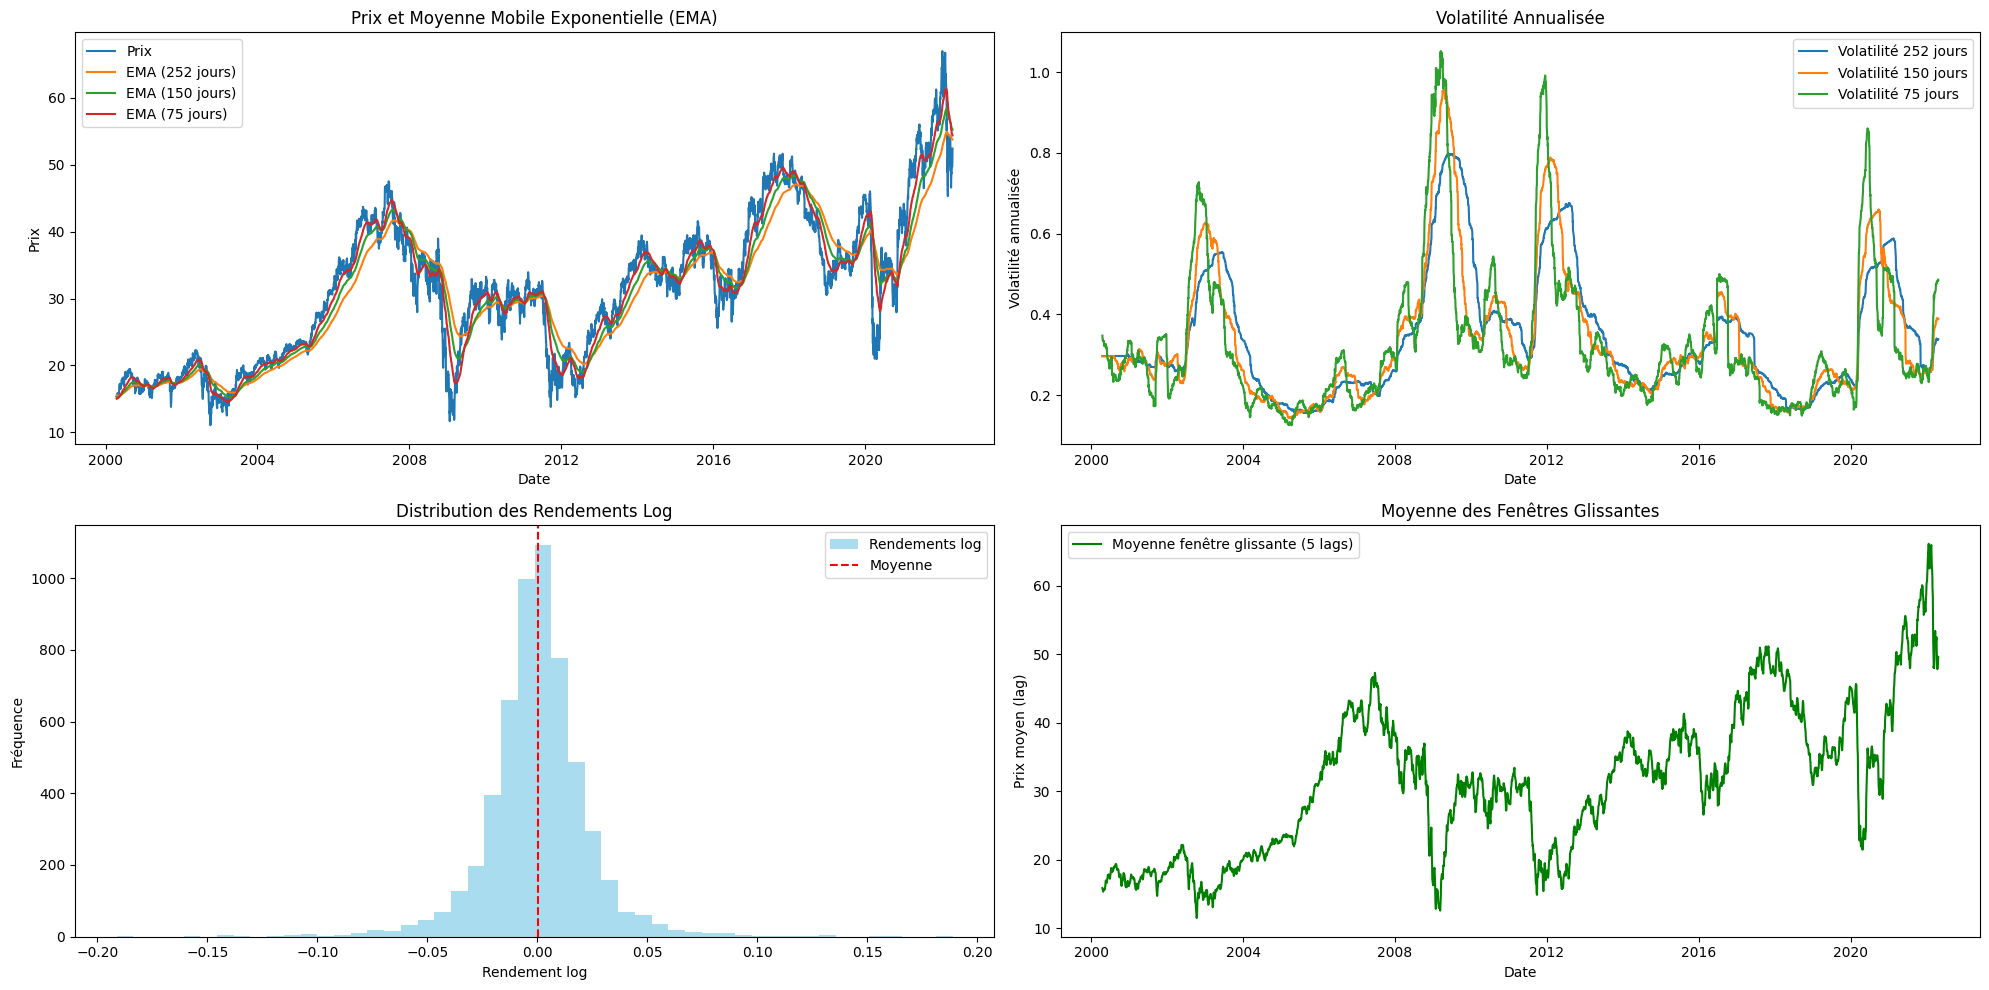

In [30]:
plt.figure(figsize=(20, 10))

# Sous-graphe 1 : Prix et EMA
plt.subplot(2, 2, 1)
plt.plot(df.index, df["Price"], label="Prix")
plt.plot(df.index, df["Price"] * df["emaRatio_252"], label="EMA (252 jours)")
plt.plot(df.index, df["Price"] * df["emaRatio_150"], label="EMA (150 jours)")
plt.plot(df.index, df["Price"] * df["emaRatio_75"], label="EMA (75 jours)")
plt.title("Prix et Moyenne Mobile Exponentielle (EMA)")
plt.xlabel("Date")
plt.ylabel("Prix")
plt.legend()

# Sous-graphe 2 : Volatilité annualisée
plt.subplot(2, 2, 2)
for K in [252, 150, 75]:
    plt.plot(df.index, df[f"vol_{K}"], label=f"Volatilité {K} jours")
plt.title("Volatilité Annualisée")
plt.xlabel("Date")
plt.ylabel("Volatilité annualisée")
plt.legend()

# Sous-graphe 3 : Distribution des rendements log
plt.subplot(2, 2, 3)
plt.hist(df["Return"], bins=50, color="skyblue", alpha=0.7, label="Rendements log")
plt.axvline(df["Return"].mean(), color="red", linestyle="--", label="Moyenne")
plt.title("Distribution des Rendements Log")
plt.xlabel("Rendement log")
plt.ylabel("Fréquence")
plt.legend()

# Sous-graphe 4 : Moyenne des fenêtres glissantes
window_avg = df[[f"Price_lag_{i+1}" for i in range(5)]].mean(axis=1)
plt.subplot(2, 2, 4)
plt.plot(df.index, window_avg, label="Moyenne fenêtre glissante (5 lags)", color="green")
plt.title("Moyenne des Fenêtres Glissantes")
plt.xlabel("Date")
plt.ylabel("Prix moyen (lag)")
plt.legend()

plt.tight_layout()
plt.show()


### Étape 4 : Séparation Temporelle des Données

#### 4.1. Division des Données
- Les données sont divisées en deux ensembles :
  - **Entraînement (Train)** : 80% des observations.
  - **Test** : 20% des observations restantes.

#### 4.2. Calcul des Dimensions
- Taille totale des données : $N = \text{len(df)}$.
- Nombre d'observations pour l'entraînement : $N_{\text{Train}} = 0.8 \times N$.
- Nombre d'observations pour le test : $N_{\text{Test}} = N - N_{\text{Train}}$.

#### 4.3. Données Séparées
- **X_train** et **X_test** : Contiennent les features après normalisation.
- **y_train** et **y_test** : Contiennent la cible.

#### Dimensions des Données :
1. **Dataset complet** : $N$
2. **Entraînement** : $N_{\text{Train}}$
3. **Test** : $N_{\text{Test}}$


In [48]:
N = len(df)
Nt = int(0.8 * N)   # Nt := N_Train
Nv = N - Nt # Nv := N_Test

X_train, X_test = X_scaled[:Nt], X_scaled[Nt:]
y_train, y_test = y[:Nt], y[Nt:]

print("\nTaille dataset complet :", N)
print("Taille train :", Nt)
print("Taille test :", Nv)


Taille dataset complet : 5520
Taille train : 4416
Taille test : 1104


### Étape 5.1 : Modèle de Régression Linéaire

#### Formule de la Régression Linéaire :
La régression linéaire modélise la relation entre une variable cible ($y$) et des variables explicatives ($X$). La formule est donnée par :
$$
\hat{y} = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \dots + \beta_p x_p
$$
où :
- $\hat{y}$ : Valeur prédite.
- $\beta_0$ : Interception (constante).
- $\beta_1, \beta_2, \dots, \beta_p$ : Coefficients de régression associés à chaque variable explicative.
- $x_1, x_2, \dots, x_p$ : Variables explicatives.

Dans sa forme matricielle, la régression linéaire peut être exprimée comme :
$$
\hat{y} = X \beta
$$
où :
- $X$ : Matrice des variables explicatives (avec une colonne de 1 pour l'interception).
- $\beta$ : Vecteur des coefficients de régression.

#### Description :
- Un modèle de **Régression Linéaire** est entraîné sur l'ensemble d'entraînement ($X_{\text{Train}}, y_{\text{Train}}$).
- Les prédictions sont effectuées sur l'ensemble de test ($X_{\text{Test}}$).

#### Métriques :
1. **Erreur quadratique moyenne (RMSE)** :
   - La formule du RMSE est donnée par :
     $$
     \text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^n (y_i - \hat{y}_i)^2}
     $$
     où :
     - $y_i$ : Valeurs réelles (cible).
     - $\hat{y}_i$ : Valeurs prédites par le modèle.
     - $n$ : Nombre total de points dans l'ensemble de test.

2. **Coefficient de détermination ($R^2$)** :
   - La formule du $R^2$ est :
     $$
     R^2 = 1 - \frac{\sum_{i=1}^n (y_i - \hat{y}_i)^2}{\sum_{i=1}^n (y_i - \bar{y})^2}
     $$
     où :
     - $\bar{y}$ : Moyenne des valeurs réelles ($y_i$).
     - $\sum_{i=1}^n (y_i - \hat{y}_i)^2$ : Somme des erreurs quadratiques (résiduelles).
     - $\sum_{i=1}^n (y_i - \bar{y})^2$ : Somme des erreurs quadratiques totales.

#### Résultats :
- **Formule du Modèle** : $\hat{y} = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \dots + \beta_p x_p$.
- **RMSE (Test)** : Affiché avec une précision de 6 décimales.
- **$R^2$ (Test)** : Affiché avec une précision de 6 décimales.


In [49]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_pred_lin = linreg.predict(X_test)

rmse_lin = np.sqrt(mean_squared_error(y_test, y_pred_lin))
r2_lin = r2_score(y_test, y_pred_lin)

print(f"\nRégression Linéaire - RMSE test : {rmse_lin:.6f}")
print(f"Régression Linéaire - R^2 test   : {r2_lin:.6f}")



Régression Linéaire - RMSE test : 0.023355
Régression Linéaire - R^2 test   : -0.053084


In [50]:
errors = np.array(y_test) - np.array(y_pred_lin)

fig = go.Figure()

# Ajout des vrais rendements
fig.add_trace(go.Scatter(
    x=list(range(len(y_test))),
    y=y_test,
    mode='lines+markers',
    name='Vrais rendements (Réels)',
    line=dict(color='blue', dash='solid'),
    marker=dict(symbol='circle'),
    opacity=0.7
))

# Ajout des prédictions
fig.add_trace(go.Scatter(
    x=list(range(len(y_pred_lin))),
    y=y_pred_lin,
    mode='lines+markers',
    name='Prédictions (Régression Linéaire)',
    line=dict(color='red', dash='dash'),
    marker=dict(symbol='x'),
    opacity=0.7
))

# Ajout des erreurs
fig.add_trace(go.Scatter(
    x=list(range(len(errors))),
    y=errors,
    mode='lines+markers',
    name='Erreur (Vrais - Prédictions)',
    line=dict(color='green', dash='dot'),
    marker=dict(symbol='triangle-up'),
    opacity=0.7
))

fig.update_layout(
    title="Vrais rendements VS Prédictions et Erreur (Régression Linéaire)",
    xaxis_title="Index Chronologique",
    yaxis_title="Rendement",
    legend=dict(font=dict(size=12)),
    grid=dict(rows=1, columns=1),
    template="plotly_white"
)

fig.show()


### Étape 5.2 : Modèle de Régression Linéaire avec Pénalisation Lasso

#### Formule de la Régression Linéaire avec Pénalisation Lasso :
La régression linéaire avec pénalisation Lasso minimise l'erreur quadratique moyenne tout en ajoutant une contrainte sur la somme des valeurs absolues des coefficients. La formule est donnée par :
$$
\hat{y} = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \dots + \beta_p x_p
$$
où la pénalité est introduite dans la fonction de coût :
$$
\text{J}(\beta) = \frac{1}{n} \sum_{i=1}^n (y_i - \hat{y}_i)^2 + \lambda \sum_{j=1}^p |\beta_j|
$$
avec :
- $y_i$ : Valeurs réelles (cible).
- $\hat{y}_i$ : Valeurs prédites par le modèle.
- $\lambda$ : Hyperparamètre de régularisation qui contrôle l'importance de la pénalité.
- $\beta_j$ : Coefficients du modèle.

La régularisation Lasso favorise la **sparsité** des coefficients ($\beta_j$), ce qui sélectionne automatiquement les variables les plus pertinentes.

---

#### Description :
- Un modèle de **Régression Linéaire avec Pénalisation Lasso** est entraîné sur l'ensemble d'entraînement ($X_{\text{Train}}, y_{\text{Train}}$).
- Les prédictions sont effectuées sur l'ensemble de test ($X_{\text{Test}}$).

---


#### Résultats :
- **Formule du Modèle** : $\hat{y} = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \dots + \beta_p x_p$, avec une pénalisation sur $\sum_{j=1}^p |\beta_j|$.
- **RMSE (Test)** : Affiché avec une précision de 6 décimales.
- **$R^2$ (Test)** : Mesure la proportion de variance expliquée par le modèle (affiché avec une précision de 6 décimales).



In [51]:
lasso = Lasso(alpha=0.0001)
lasso.fit(X_train, y_train)

y_pred_lasso = lasso.predict(X_test)

rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
r2_lasso = r2_score(y_test, y_pred_lasso)

print(f"\nRégression Lasso - RMSE test : {rmse_lasso:.6f}")
print(f"Régression Lasso - R^2 test   : {r2_lasso:.6f}")




Régression Lasso - RMSE test : 0.023053
Régression Lasso - R^2 test   : -0.026013


In [52]:
errors_lasso = np.array(y_test) - np.array(y_pred_lasso)

fig_lasso = go.Figure()

# Ajout des vrais rendements
fig_lasso.add_trace(go.Scatter(
    x=list(range(len(y_test))),
    y=y_test,
    mode='lines+markers',
    name='Vrais rendements (Réels)',
    line=dict(color='blue', dash='solid'),
    marker=dict(symbol='circle'),
    opacity=0.7
))

# Ajout des prédictions Lasso
fig_lasso.add_trace(go.Scatter(
    x=list(range(len(y_pred_lasso))),
    y=y_pred_lasso,
    mode='lines+markers',
    name='Prédictions (Régression Lasso)',
    line=dict(color='red', dash='dash'),
    marker=dict(symbol='x'),
    opacity=0.7
))

# Ajout des erreurs pour Lasso
fig_lasso.add_trace(go.Scatter(
    x=list(range(len(errors_lasso))),
    y=errors_lasso,
    mode='lines+markers',
    name='Erreur (Vrais - Prédictions Lasso)',
    line=dict(color='green', dash='dot'),
    marker=dict(symbol='triangle-up'),
    opacity=0.7
))

fig_lasso.update_layout(
    title="Vrais rendements VS Prédictions et Erreur (Régression Lasso)",
    xaxis_title="Index Chronologique",
    yaxis_title="Rendement",
    legend=dict(font=dict(size=12)),
    grid=dict(rows=1, columns=1),
    template="plotly_white"
)

fig_lasso.show()


### Étape 5.3 : Modèle Random Forest

#### Description :
- Un modèle de **Random Forest Regressor** est entraîné sur l'ensemble d'entraînement ($X_{\text{Train}}, y_{\text{Train}}$).
- Les prédictions sont effectuées sur l'ensemble de test ($X_{\text{Test}}$).
- Le modèle **Random Forest** combine plusieurs arbres de décision (généralement construits sur des sous-échantillons des données) et effectue une agrégation (par moyenne des prédictions) pour améliorer la précision et réduire le risque de sur-apprentissage.

#### Fonctionnement du Modèle :
1. **Arbres de décision multiples** :
   - Chaque arbre est construit à partir d'un sous-échantillon aléatoire des données.
   - Les caractéristiques utilisées pour construire chaque arbre sont également sélectionnées aléatoirement.
2. **Prédiction globale** :
   - Pour un point $x_i$, la prédiction finale $\hat{y}_i$ est donnée par la moyenne des prédictions individuelles des arbres :
     $$
     \hat{y}_i = \frac{1}{T} \sum_{t=1}^T \hat{y}_i^{(t)}
     $$
     où :
     - $T$ : Nombre total d'arbres.
     - $\hat{y}_i^{(t)}$ : Prédiction du $t^\text{ème}$ arbre pour $x_i$.

#### Résultats :
- **RMSE (Test)** : Affiché avec une précision de 6 décimales.
- **$R^2$ (Test)** : Mesure la proportion de variance expliquée par le modèle (affiché avec une précision de 6 décimales).


In [14]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print(f"\nRégression Random Forest - RMSE test : {rmse_rf:.6f}")
print(f"Régression Random Forest - R^2 test   : {r2_rf:.6f}")



Régression Random Forest - RMSE test : 0.023220
Régression Random Forest - R^2 test   : -0.210179


In [12]:
errors_rf = np.array(y_test) - np.array(y_pred_rf)

fig_rf = go.Figure()

# Ajout des vrais rendements
fig_rf.add_trace(go.Scatter(
    x=list(range(len(y_test))),
    y=y_test,
    mode='lines+markers',
    name='Vrais rendements (Réels)',
    line=dict(color='blue', dash='solid'),
    marker=dict(symbol='circle'),
    opacity=0.7
))

# Ajout des prédictions Random Forest
fig_rf.add_trace(go.Scatter(
    x=list(range(len(y_pred_rf))),
    y=y_pred_rf,
    mode='lines+markers',
    name='Prédictions (Random Forest)',
    line=dict(color='red', dash='dash'),
    marker=dict(symbol='x'),
    opacity=0.7
))

# Ajout des erreurs pour Random Forest
fig_rf.add_trace(go.Scatter(
    x=list(range(len(errors_rf))),
    y=errors_rf,
    mode='lines+markers',
    name='Erreur (Vrais - Prédictions RF)',
    line=dict(color='green', dash='dot'),
    marker=dict(symbol='triangle-up'),
    opacity=0.7
))

fig_rf.update_layout(
    title="Vrais rendements VS Prédictions et Erreur (Random Forest)",
    xaxis_title="Index Chronologique",
    yaxis_title="Rendement",
    legend=dict(font=dict(size=12)),
    grid=dict(rows=1, columns=1),
    template="plotly_white"
)

fig_rf.show()


### Étape 6 : Analyse des Features Importantes

#### Description :
Cette étape consiste à identifier les features les plus importantes pour chaque modèle (Régression Linéaire, Régression Lasso, Random Forest) afin de mieux comprendre les contributions des différentes variables.

#### Étapes Réalisées :
1. **Régression Linéaire** :
   - Les coefficients du modèle sont extraits et triés par leur valeur absolue.
   - Seules les 10 features les plus importantes sont affichées pour une meilleure lisibilité.

2. **Régression Lasso** :
   - Les coefficients du modèle Lasso sont extraits et triés par leur valeur absolue.
   - Limitation aux 10 principales features.

3. **Random Forest** :
   - Les importances des features sont calculées à partir de l'arbre d'ensemble.
   - Les 10 features les plus importantes sont affichées.

#### Graphiques Affichés :
- **Graphique 1** : Top 10 des features les plus importantes pour la Régression Linéaire.
- **Graphique 2** : Top 10 des features les plus importantes pour la Régression Lasso.
- **Graphique 3** : Top 10 des features les plus importantes pour le modèle Random Forest.

#### Résultat :
Les graphiques permettent de comparer les features les plus significatives pour chaque méthode et d'observer comment chaque modèle les évalue en fonction de sa logique d'entraînement.


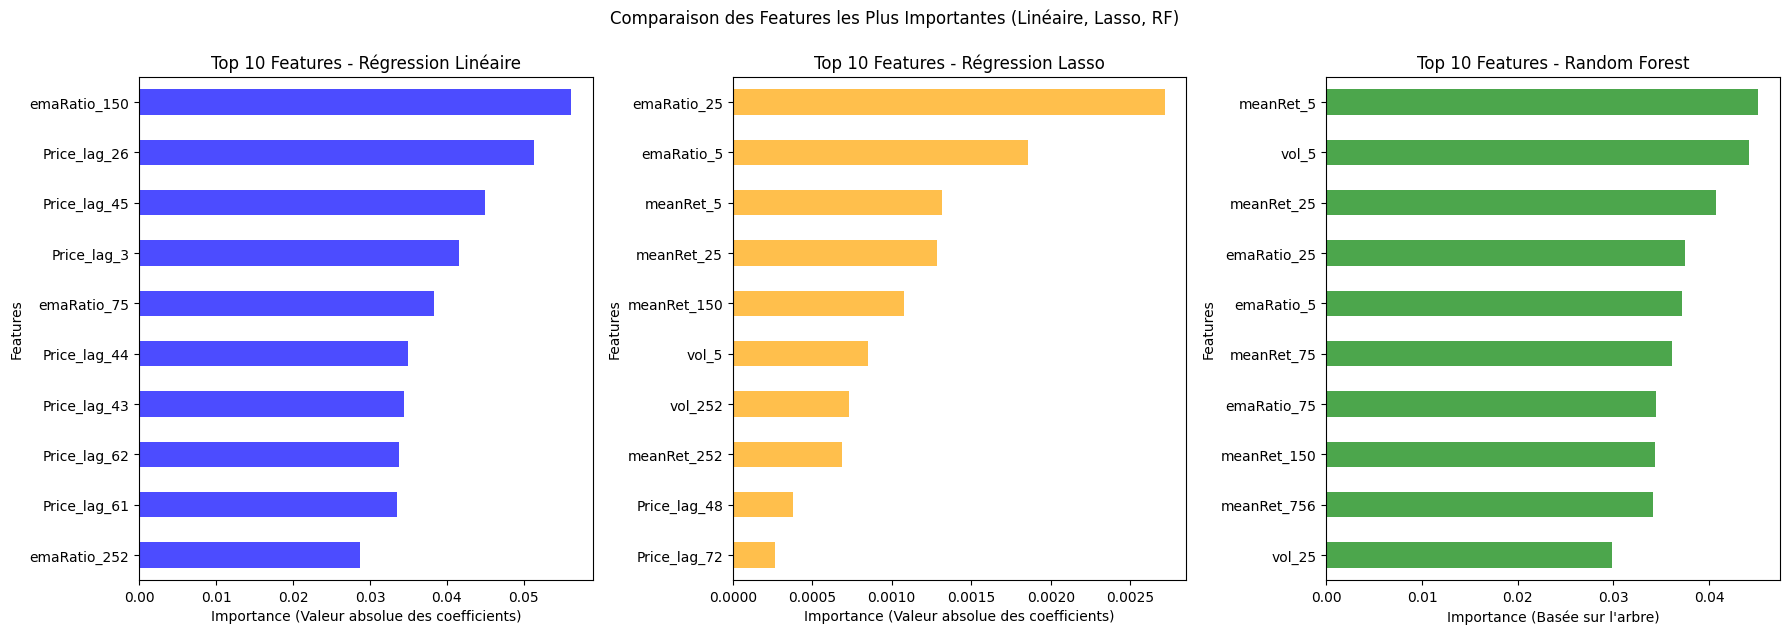

In [15]:
coefficients_linreg = pd.Series(linreg.coef_, index=df[feature_cols].columns)
coefficients_linreg = coefficients_linreg.abs().sort_values(ascending=False)

coefficients_lasso = pd.Series(lasso.coef_, index=df[feature_cols].columns)
coefficients_lasso = coefficients_lasso.abs().sort_values(ascending=False)

importances_rf = pd.Series(rf.feature_importances_, index=df[feature_cols].columns)
importances_rf = importances_rf.sort_values(ascending=False)

top_n = 10
top_features_linreg = coefficients_linreg.head(top_n)
top_features_lasso = coefficients_lasso.head(top_n)
top_features_rf = importances_rf.head(top_n)

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
top_features_linreg.plot(kind='barh', color='blue', alpha=0.7)
plt.title("Top 10 Features - Régression Linéaire")
plt.xlabel("Importance (Valeur absolue des coefficients)")
plt.ylabel("Features")
plt.gca().invert_yaxis()  

plt.subplot(1, 3, 2)
top_features_lasso.plot(kind='barh', color='orange', alpha=0.7)
plt.title("Top 10 Features - Régression Lasso")
plt.xlabel("Importance (Valeur absolue des coefficients)")
plt.ylabel("Features")
plt.gca().invert_yaxis()

plt.subplot(1, 3, 3)
top_features_rf.plot(kind='barh', color='green', alpha=0.7)
plt.title("Top 10 Features - Random Forest")
plt.xlabel("Importance (Basée sur l'arbre)")
plt.ylabel("Features")
plt.gca().invert_yaxis()

plt.tight_layout()
plt.suptitle("Comparaison des Features les Plus Importantes (Linéaire, Lasso, RF)", y=1.05)
plt.show()


### Analyse Comparée des Features Importantes

1. **Régression Linéaire** :
   - Met en avant les moyennes mobiles exponentielles (e.g., `emaRatio_150`) et les décalages de prix (`Price_lag`).
   - Importance des tendances à moyen terme dans les prédictions.

2. **Régression Lasso** :
   - Favorise des variables courtes grâce à une régularisation plus forte.
   - Les tendances court terme (`emaRatio_25`, `emaRatio_5`) et les métriques comme les rendements moyens (`meanRet`) et la volatilité (`vol_5`) dominent.

3. **Random Forest** :
   - Privilégie les indicateurs récents comme les rendements moyens (`meanRet_5`) et la volatilité (`vol_5`).
   - Capture efficacement les fluctuations à court terme.

### Conclusion
- Chaque modèle met en avant des variables distinctes, reflétant leurs mécanismes d'entraînement :
  - **Linéaire** : Importance des tendances à moyen terme.
  - **Lasso** : Signaux courts et compressés.
  - **Random Forest** : Fluctuations récentes.


In [16]:
results = {
    "Modèle": ["Régression Linéaire", "Régression Lasso", "Random Forest"],
    "RMSE (Test)": [rmse_lin, rmse_lasso, rmse_rf],
    "R² (Test)": [r2_lin, r2_lasso, r2_rf]
}

results_df = pd.DataFrame(results)

from IPython.display import display
display(results_df)



,Modèle,RMSE (Test),R² (Test)
0,Régression Linéaire,0.021756,-0.062385
1,Régression Lasso,0.021231,-0.011724
2,Random Forest,0.023220,-0.210179


### Commentaire sur les Résultats

#### 1. Analyse des RMSE
- **Régression Lasso** : RMSE le plus faible ($0.021231$), indiquant une meilleure précision des prédictions.
- **Régression Linéaire** : RMSE légèrement supérieur ($0.021756$), moins performant que Lasso.
- **Random Forest** : RMSE le plus élevé ($0.023220$), indiquant une performance plus faible ou une optimisation insuffisante.

#### 2. Analyse des $R^2$
- Tous les modèles ont des $R^2$ **négatifs**, indiquant une performance inférieure à une prédiction basée sur la moyenne.
  - **Lasso** : Meilleur $R^2$ ($-0.011724$), expliquant légèrement mieux la variance.
  - **Linéaire** : $R^2$ intermédiaire ($-0.062385$), moins performant que Lasso.
  - **Random Forest** : $R^2$ le plus faible ($-0.210179$), montrant une inadéquation avec les données.

#### 3. Conclusion
- **Lasso** est le modèle le plus performant, mais les $R^2$ négatifs montrent que les données ou les modèles nécessitent des ajustements.
- Suggestions d'amélioration :
  - Ajouter ou transformer des features pour réduire le bruit.
  - Optimiser les hyperparamètres (e.g., `alpha` pour Lasso, `n_estimators` pour Random Forest).
  - Tester des modèles avancés (XGBoost, LightGBM, ou réseaux neuronaux) pour capturer des relations complexes.



## Étape 7 : Pré-traitement des Données pour les Séries Temporelles

#### Objectif
- Préparer les données au format séquentiel pour entraîner un modèle de séries temporelles.
- Prédire l'intervalle du rendement futur ($FutureReturn$) selon l'approche de Mr. Brugière et Mr. Turinici.

#### Étapes Réalisées
1. **Discrétisation des Rendements** :
   - $FutureReturn$ est discrétisé en $n$ intervalles (quantiles), chaque intervalle correspondant à une classe.

2. **Séparation des Données** :
   - Division en ensemble d'entraînement (80%) et de test (20%).
   - Normalisation via `StandardScaler`.

3. **Création des Séquences** :
   - Découpage en séquences de longueur fixe ($seq\_length = 35$).
   - Chaque séquence inclut $seq\_length$ observations consécutives.

4. **Conversion en Catégories** :
   - Les cibles ($FutureReturn\_bucket$) sont encodées en one-hot pour la classification multi-classes.

#### Résultat
- Les données sont prêtes pour l'entraînement d'un modèle temporel :
  - **$X_{train\_seq}$** : Séquences d'entraînement ($\text{shape} = (\text{n\_samples}, seq\_length, n\_features)$).
  - **$y_{train\_seq}$** : Cibles d'entraînement ($\text{shape} = (\text{n\_samples}, n\_classes)$).


In [53]:
df_seq = df.copy()

n_buckets = 7
quantiles = np.linspace(0, 1, n_buckets+1)  
cuts = df_seq['FutureReturn'].quantile(quantiles).values

print("quantiles:", cuts)

df_seq['FutureReturn_bucket'] = pd.cut(
    df_seq['FutureReturn'],
    bins=cuts,            
    labels=False,         
    include_lowest=True   
)

exclude_cols_seq = ["Price", "Return", "FutureReturn", "FutureReturn_bucket"]
feature_cols_seq = [c for c in df_seq.columns if c not in exclude_cols_seq]
X_seq = df_seq[feature_cols_seq].values
y_seq = df_seq["FutureReturn_bucket"].values.astype(int)  

N_seq = len(df_seq)
Nt_seq = int(0.8 * N_seq)
Nv_seq = N_seq - Nt_seq

X_train_seq, X_test_seq = X_seq[:Nt_seq], X_seq[Nt_seq:]
y_train_seq, y_test_seq = y_seq[:Nt_seq], y_seq[Nt_seq:]
scaler_seq = StandardScaler()
X_train_scaled_seq = scaler_seq.fit_transform(X_train_seq)
X_test_scaled_seq  = scaler_seq.transform(X_test_seq)

seq_length = 35

def create_sequences(X, y, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length])
    return np.array(X_seq), np.array(y_seq)


X_train_seq, y_train_seq = create_sequences(X_train_scaled_seq, y_train_seq, seq_length)
X_test_seq,  y_test_seq  = create_sequences(X_test_scaled_seq,  y_test_seq,  seq_length)

print(f"Forme X_train_seq : {X_train_seq.shape}")
print(f"Forme y_train_seq : {y_train_seq.shape}")

y_train_cat = to_categorical(y_train_seq, num_classes=n_buckets)
y_test_cat  = to_categorical(y_test_seq,  num_classes=n_buckets)

loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=False)



quantiles: [-0.19116565 -0.01875568 -0.00897445 -0.0028358   0.00316597  0.00952873
  0.01946171  0.18874477]
Forme X_train_seq : (4381, 35, 93)
Forme y_train_seq : (4381,)


### Étape 7.1 : Construction du Modèle LSTM

#### Description
- Création d'un modèle LSTM pour traiter les données séquentielles.
- Objectif : prédire l'intervalle du rendement futur ($FutureReturn\_bucket$) via une classification multi-classes.

#### Architecture du Modèle
1. **Entrée** : Forme des séquences temporelles ($seq\_length, n\_features$).
2. **Couches LSTM** :
   - Première couche LSTM avec 64 unités, retournant des séquences.
   - Deuxième couche LSTM avec 64 unités, retournant un vecteur final.
3. **Couches Intermédiaires** :
   - Dropout (0.1) pour réduire le sur-apprentissage.
   - Couche dense avec 32 unités et activation `relu`.
4. **Sortie** :
   - Couche dense avec $n\_buckets$ unités et activation `softmax` pour la classification.

#### Compilation
- **Optimiseur** : Adam avec un taux d'apprentissage de 0.001.
- **Fonction de perte** : Categorical Crossentropy.
- **Métrique** : Précision (`accuracy`).


In [54]:
model_lstm = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(seq_length, X_train_seq.shape[2])),
    tf.keras.layers.LSTM(128, return_sequences=True, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.LSTM(64, return_sequences=False, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(n_buckets, activation='softmax')  
])

model_lstm.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

model_lstm.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 35, 128)        │       113,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 35, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 165,383 (646.03 KB)

 Trainable params: 165,383 (646.03 KB)

 Non-trainable params: 0 (0.00 B)

In [55]:
history_lstm = model_lstm.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_test_seq, y_test_seq),
    epochs=10,
    batch_size=32,
    verbose=1
)

test_loss_lstm, test_acc_lstm = model_lstm.evaluate(X_test_seq, y_test_seq, verbose=0)
print(f"\nTest loss (cross-entropy) : {test_loss_lstm:.4f}")
print(f"Test accuracy             : {test_acc_lstm:.2%}")
y_proba_lstm = model_lstm.predict(X_test_seq)
predicted_buckets_lstm = np.argmax(y_proba_lstm, axis=1)


Epoch 1/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 15s 65ms/step - accuracy: 0.1527 - loss: 2.2448 - val_accuracy: 0.1590 - val_loss: 2.1182
Epoch 2/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - accuracy: 0.1845 - loss: 1.9222 - val_accuracy: 0.1646 - val_loss: 1.9280
Epoch 3/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - accuracy: 0.2054 - loss: 1.8927 - val_accuracy: 0.1506 - val_loss: 1.9563
Epoch 4/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 12s 84ms/step - accuracy: 0.2063 - loss: 1.8829 - val_accuracy: 0.1497 - val_loss: 1.9556
Epoch 5/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 22s 97ms/step - accuracy: 0.2075 - loss: 1.8846 - val_accuracy: 0.1515 - val_loss: 1.9733
Epoch 6/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 12s 85ms/step - accuracy: 0.2180 - loss: 1.8778 - val_accuracy: 0.1478 - val_loss: 1.9563
Epoch 7/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.2118 - loss: 1.8745 - val_accuracy: 0.1506 - val_loss: 1.9550
Epoch 8/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 11s 79ms/step - accuracy: 0.2126 - loss: 1.8749 - 

#### Evolution de la Loss pour le train et le test

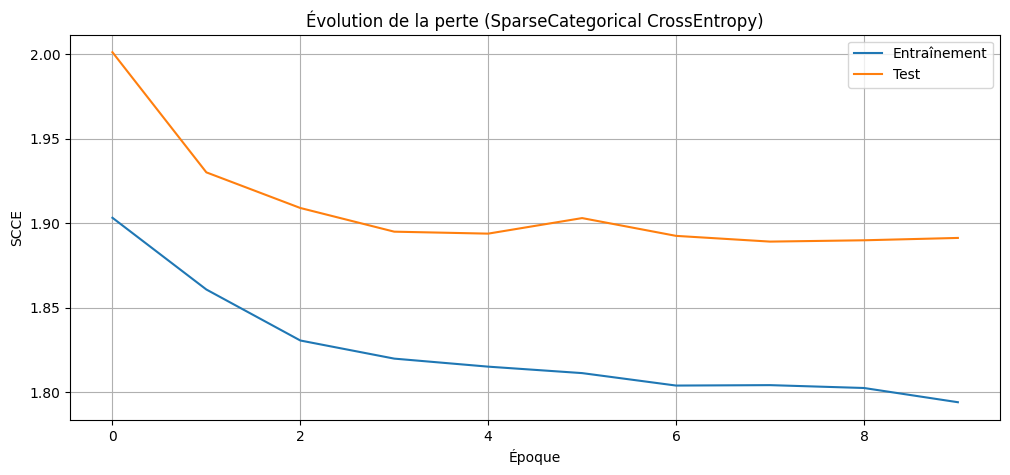

In [24]:
plt.figure(figsize=(12, 5))
plt.plot(history_lstm.history['loss'], label='Entraînement')
plt.plot(history_lstm.history['val_loss'], label='Test')
plt.title('Évolution de la perte (SparseCategorical CrossEntropy)')
plt.xlabel('Époque')
plt.ylabel('SCCE')
plt.legend()
plt.grid(True)
plt.show()



#### Comparaison des Répartitions Réelles et Prédites

#### Objectif
- Analyser la correspondance entre les fréquences réelles des classes ($y_{\text{test}}$) et les fréquences prédites :
  1. Basées sur les classes prédominantes ($\arg\max$).
  2. Basées sur les probabilités moyennes des prédictions pour chaque classe.

#### Méthodologie
1. **Fréquences Réelles ($\text{true\_freq}$)** :
   - Calculées comme la proportion des occurrences dans les données réelles :  
     $\text{true\_freq}_i = \frac{\text{count}(y_{\text{test}} = i)}{\sum_{j=1}^{n_{\text{buckets}}} \text{count}(y_{\text{test}} = j)}$

2. **Fréquences Prédites - $\arg\max$ ($\text{pred\_freq}$)** :
   - Calculées comme la proportion des prédictions $\hat{y}$ assignées à chaque classe :  
     $\text{pred\_freq}_i = \frac{\text{count}(\hat{y} = i)}{\sum_{j=1}^{n_{\text{buckets}}} \text{count}(\hat{y} = j)}$

3. **Probabilités Moyennes Prédites ($\text{mean\_proba}$)** :
   - Moyenne des probabilités prédites pour chaque classe $i$ :  
     $\text{mean\_proba}_i = \frac{1}{N} \sum_{k=1}^{N} \hat{P}_k(i)$  
     où $\hat{P}_k(i)$ est la probabilité prédite pour la classe $i$ à l'échantillon $k$.

#### Résultats
1. **Graphique 1** : Répartition réelle vs prédite ($\arg\max$)  
   Compare les fréquences réelles des classes avec celles des prédictions $\arg\max(\hat{P})$.

2. **Graphique 2** : Répartition réelle vs probabilités moyennes  
   Compare les fréquences réelles des classes avec les moyennes des probabilités prédites.

#### Interprétation
- **Graphique 1** : Évalue l'alignement entre la distribution des classes réelles et les prédictions catégoriques ($\arg\max$).
- **Graphique 2** : Analyse si les prédictions probabilistes (moyennes) reflètent la répartition réelle des données.



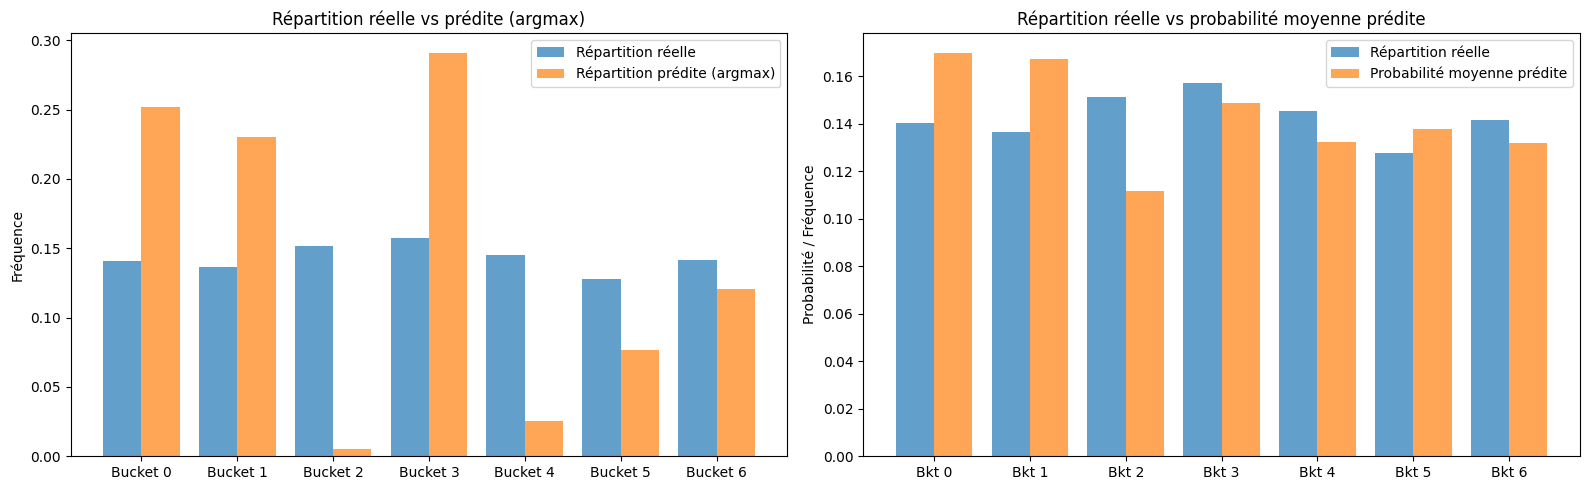

In [95]:
# Calcul des fréquences  (true_freq)
true_counts = np.bincount(y_test_seq, minlength=n_buckets)  
true_freq = true_counts / true_counts.sum()  

# Calcul des fréquences prédites (argmax) (pred_freq)
pred_counts = np.bincount(predicted_buckets_lstm, minlength=n_buckets)  
pred_freq = pred_counts / pred_counts.sum()  


n_buckets = len(true_freq) 
indices = np.arange(n_buckets)
bar_width = 0.4


plt.figure(figsize=(16, 5))

# Graphique 1 : Répartition réelle vs prédite (argmax)
plt.subplot(1, 2, 1)
plt.bar(indices - bar_width / 2, true_freq, width=bar_width, alpha=0.7, label="Répartition réelle")
plt.bar(indices + bar_width / 2, pred_freq, width=bar_width, alpha=0.7, label="Répartition prédite (argmax)")
plt.xticks(indices, [f"Bucket {i}" for i in indices])
plt.ylabel("Fréquence")
plt.title("Répartition réelle vs prédite (argmax)")
plt.legend()

mean_proba = y_proba_lstm.mean(axis=0)  

# Graphique 2 : Répartition réelle vs probabilité moyenne
plt.subplot(1, 2, 2)
plt.bar(indices - bar_width / 2, true_freq, width=bar_width, alpha=0.7, label="Répartition réelle")
plt.bar(indices + bar_width / 2, mean_proba, width=bar_width, alpha=0.7, label="Probabilité moyenne prédite")
plt.xticks(indices, [f"Bkt {i}" for i in indices])
plt.ylabel("Probabilité / Fréquence")
plt.title("Répartition réelle vs probabilité moyenne prédite")
plt.legend()

plt.tight_layout()
plt.show()


### Commentaire :

1. **Graphique 1 : Répartition réelle vs prédite (argmax)** :
   - La classe prédite dominante (par exemple, Bucket 1) varie selon les exécutions du modèle, suggérant une sensibilité au réentraînement ou au tirage aléatoire des données.
   - Les autres classes peuvent être sous-représentées, indiquant que le modèle peine à équilibrer la prédiction entre les différentes catégories.

2. **Graphique 2 : Répartition réelle vs probabilité moyenne prédite** :
   - Les probabilités moyennes prédites montrent généralement une meilleure répartition que les prédictions argmax, mais les écarts persistent avec les fréquences réelles, notamment pour certains Buckets.
   - Ces variations observées lors de différentes exécutions indiquent que le modèle capture partiellement les tendances globales tout en restant sensible à des biais structurels ou aux fluctuations aléatoires.

#### Conclusion :
- Les résultats montrent une certaine instabilité d'une exécution à l'autre, soulignant l'importance :
  - D'optimiser les hyperparamètres pour améliorer la généralisation.
  - D'ajouter des mécanismes de régularisation ou d'améliorer le traitement des données pour réduire les biais entre les classes.
  - D'utiliser plusieurs runs pour une évaluation plus robuste des performances globales.



### Étape 7.2 : Construction du Modèle Temporal Fusion Transformer (TFT)

#### Description
- Le modèle est basé sur l’architecture **Temporal Fusion Transformer (TFT)**, conçue pour traiter des séries temporelles multivariées.
- **Objectif** : prédire l’intervalle (ou le bucket) auquel appartient le rendement futur ($FutureReturn\_bucket$) via une classification multi‐classes.

---

#### Architecture du Modèle

1. **Entrée**  
   - Les données d’entrée sont sous forme de tenseurs 3D : $$(\text{batch}, \text{seq\_length}, \text{num\_features}).$$  
   - Chaque séquence est composée de $\text{seq\_length}$ pas de temps, et chaque pas de temps contient $\text{num\_features}$ caractéristiques (ex. : variables historiques et exogènes).  
   - Le modèle intègre ces séquences pour produire une prédiction multi‐classes ($n\_buckets$).

2. **Variable Selection Network (VSN)**  
   - **Objectif** : sélectionner dynamiquement les variables les plus pertinentes pour chaque pas de temps, tout en permettant des interactions complexes entre elles.
   - Le VSN se compose de deux blocs :
     - **Flattened GRN** :  
       Un réseau de résidus (GRN) génère des poids d'importance (via une fonction softmax) pour chaque variable en fonction de l'entrée complète.  
       $$ \text{sparse\_weights} = \text{softmax}\bigl(\text{GRN}(\text{input})\bigr). $$
     - **GRN individuel par variable** :  
       Chaque variable passe par son propre GRN, afin de transformer ses caractéristiques en représentations plus riches.  
       $$ \text{output} = \sum_{i=1}^{n\_vars} \text{sparse\_weights}[i] \cdot \text{GRN}_i\bigl(\text{variable}_i\bigr). $$
   - Le VSN est appliqué deux fois : pour l’**encodeur** et pour le **décodeur**.

3. **Encodage Positionnel**  
   - Chaque pas de temps reçoit un vecteur d’encodage positionnel pour capturer l’ordre temporel dans la séquence.  
   - Les encodages sont définis comme :
     $$
       \text{PE}_{(i,2k)} = \sin\Bigl(\frac{i}{\,10000^{\,2k/d_{\text{model}}}}\Bigr),
       \quad
       \text{PE}_{(i,2k+1)} = \cos\Bigl(\frac{i}{\,10000^{\,2k/d_{\text{model}}}}\Bigr),
     $$
     où $i$ est l’indice du pas de temps, $k$ la dimension, et $d_{\text{model}}$ la taille des représentations.

4. **Encodeur et Décodeur LSTM**  
   - **Encodeur LSTM**  
     Transforme les représentations (après le VSN) en capturant les relations complexes des données historiques.  
     $$ h_t = \text{LSTM}(x_t, h_{t-1}). $$
   - **Décodeur LSTM**  
     Reçoit en entrée les séquences futures (ou ciblées) et s’appuie sur les états du LSTM encodeur pour prédire le rendement futur (bucket).

5. **Fusion Encodeur‐Décodeur**  
   - Les sorties des LSTMs encodeur et décodeur sont concaténées :
     $$ \text{combined} = [\,\text{encoder\_out}, \,\text{decoder\_out}\,]. $$
   - On applique ensuite un **GLU (Gated Linear Unit)** pour moduler ces sorties :
     $$ \text{GLU}(x) = \text{Dense}(x) \,\times\, \sigma\bigl(\text{Dense}(x)\bigr), $$
     où $\sigma$ est la fonction sigmoïde.

6. **Multi‐Head Attention**  
   - **Objectif** : capturer des relations complexes entre la sortie de l’encodeur et celle du décodeur, en mettant l’accent sur les dépendances temporelles.  
   - Définie comme :
     $$
       \text{Attention}(Q, K, V) = 
         \text{softmax}\Bigl(\frac{Q\,K^\mathsf{T}}{\sqrt{\,d_k\,}}\Bigr) V,
     $$
     où $Q$, $K$, et $V$ sont respectivement les requêtes, clés et valeurs dérivées des représentations encodeur/décodeur.

7. **Position‐Wise Feed‐Forward Network (FFN)**  
   - Une transformation finale, appliquée pas par pas, affine les représentations produites par l'attention :
     $$
       \text{FFN}(x) = \text{ReLU}(x\,W_1 + b_1)\,W_2 + b_2.
     $$

8. **Sortie**  
   - Une couche dense avec $n\_buckets$ neurones (activation softmax) prédit la classe finale, c’est‐à‐dire le bucket du rendement futur :
     $$
       \hat{y}_i 
       = \frac{\exp(z_i)}{\displaystyle \sum_{j=1}^{n\_buckets} \exp(z_j)},
     $$
     où $z_i$ est le logit associé à la classe $i$.

---

#### Compilation du Modèle
- **Optimiseur** : Adam, avec un taux d’apprentissage $\alpha = 0.001$.  
- **Fonction de perte** : *Sparse Categorical Crossentropy*  
  $$
  \mathcal{L} = -\,\frac{1}{N} \,\sum_{i=1}^{N} \log\!\bigl(\hat{P}(y_i)\bigr).
  $$
- **Métrique** : Précision ($\text{accuracy}$).

---

#### Points Clés

1. Le **VSN** (Variable Selection Network) identifie dynamiquement les variables les plus pertinentes à chaque pas de temps.  
2. L’**encodage positionnel** garantit que la dimension temporelle est préservée, même dans les blocs de type Transformer.  
3. Les **LSTMs encodeur/décodeur** capturent les dépendances temporelles passées et futures.  
4. L’**attention multi‐têtes** (Multi‐Head Attention) extrait des relations complexes entre les représentations encodeur et décodeur.  
5. La **sortie softmax** fournit des probabilités pour chaque bucket (classe), rendant la prédiction interprétable.

En somme, le TFT combine plusieurs mécanismes (VSN, LSTM, Attention, FFN) pour offrir une architecture puissante, adaptée aux séries temporelles univariées ou multivariées, que ce soit pour la **prédiction** (régression) ou la **classification** multiclasse.


In [96]:
###############################################################################
# 1) Gated Linear Unit (GLU)
###############################################################################
class GLU(layers.Layer):
    def __init__(self, units, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.gate_dense = layers.Dense(units)
        self.linear_dense = layers.Dense(units)
        self.sigmoid = tf.keras.activations.sigmoid

    def call(self, x):
        gate = self.sigmoid(self.gate_dense(x))
        lin = self.linear_dense(x)
        return gate * lin

###############################################################################
# 2) GatedResidualNetwork (GRN)
###############################################################################
class GatedResidualNetwork(layers.Layer):
    def __init__(self, d_hidden, d_out, dropout_rate=0.1, **kwargs):
        super().__init__(**kwargs)
        self.fc1 = layers.Dense(d_hidden)
        self.elu1 = layers.Activation('elu')
        self.fc2 = layers.Dense(d_out)
        self.dropout = layers.Dropout(dropout_rate)
        self.gate = GLU(d_out)
        self.bn = layers.BatchNormalization(axis=-1)

    def call(self, x):
        residual = x
        x = self.fc1(x)
        x = self.elu1(x)
        x = self.fc2(x)
        x = self.dropout(x)
        x = self.gate(x)
        return self.bn(x + residual)

###############################################################################
# 3) VariableSelectionNetwork (VSN)
###############################################################################
class VariableSelectionNetwork(layers.Layer):
    def __init__(self, num_features, d_hidden, d_out, dropout_rate=0.1, **kwargs):
        super().__init__(**kwargs)
        self.flatten_grn = GatedResidualNetwork(d_hidden, num_features, dropout_rate)
        self.var_grns = [GatedResidualNetwork(d_hidden, d_out, dropout_rate) for _ in range(num_features)]
        self.softmax = layers.Softmax(axis=-1)

    def call(self, x):
        logits = self.flatten_grn(x)
        sparse_weights = self.softmax(logits)

        var_outputs = []
        for i in range(x.shape[-1]):
            var_outputs.append(self.var_grns[i](x[..., i:i+1]))
        var_outputs = tf.stack(var_outputs, axis=-1)

        weighted_output = tf.reduce_sum(var_outputs * tf.expand_dims(sparse_weights, axis=-2), axis=-1)
        return weighted_output, sparse_weights

###############################################################################
# 4) Temporal Fusion Transformer (TFT)
###############################################################################
class TemporalFusionTransformer(Model):
    def __init__(self, seq_len, num_features, d_model=32, num_heads=4, dff=64, dropout_rate=0.1, n_buckets=7, **kwargs):
        super().__init__(**kwargs)
        self.seq_len = seq_len
        self.num_features = num_features
        self.d_model = d_model

        # Variable Selection Networks
        self.encoder_vsn = VariableSelectionNetwork(num_features, d_model, d_model, dropout_rate)
        self.decoder_vsn = VariableSelectionNetwork(num_features, d_model, d_model, dropout_rate)

        # LSTM encodeur et décodeur
        self.encoder_lstm = layers.LSTM(d_model, return_sequences=True)
        self.decoder_lstm = layers.LSTM(d_model, return_sequences=True)

        # Post-LSTM GLU et BatchNorm
        self.post_lstm_glu = GLU(d_model)
        self.post_lstm_bn = layers.BatchNormalization(axis=-1)

        # Multihead attention
        self.attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.attn_glu = GLU(d_model)
        self.attn_bn = layers.BatchNormalization(axis=-1)

        # Position-wise feed-forward network
        self.poswise_ff = GatedResidualNetwork(dff, d_model, dropout_rate)
        self.pos_ff_glu = GLU(d_model)
        self.pos_ff_bn = layers.BatchNormalization(axis=-1)

        self.final_dense = layers.Dense(n_buckets, activation='softmax')

    def call(self, inputs):
        enc_len = self.seq_len // 2
        dec_len = self.seq_len - enc_len
        x_enc = inputs[:, :enc_len, :] 
        x_dec = inputs[:, enc_len:, :]  

        enc_out, _ = self.encoder_vsn(x_enc)
        dec_out, _ = self.decoder_vsn(x_dec)

        enc_lstm = self.encoder_lstm(enc_out)
        dec_lstm = self.decoder_lstm(dec_out)

        combined = tf.concat([enc_lstm, dec_lstm], axis=1)
        combined = self.post_lstm_glu(combined)
        combined = self.post_lstm_bn(combined)

        enc_part = combined[:, :enc_len, :]
        dec_part = combined[:, enc_len:, :]
        attn_out = self.attention(dec_part, enc_part)
        attn_out = self.attn_glu(attn_out) + dec_part
        attn_out = self.attn_bn(attn_out)

        ff_out = self.poswise_ff(attn_out)
        ff_out = self.pos_ff_glu(ff_out) + attn_out
        ff_out = self.pos_ff_bn(ff_out)

        last_step = ff_out[:, -1, :]
        return self.final_dense(last_step)


In [97]:
seq_length = 35     
n_vars = X_train_seq.shape[2]  
n_buckets = 7                  
batch_size = 32               

model_TFT = TemporalFusionTransformer(
    seq_len=seq_length,
    num_features=n_vars,  
    d_model=32,
    num_heads=4,
    dff=64,
    dropout_rate=0.1,
    n_buckets=n_buckets
)

#### Train du modèle TFT

In [62]:
model_TFT.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),  
    metrics=['accuracy']
)

history_TFT = model_TFT.fit(
    X_train_seq,  
    y_train_seq,  
    validation_data=(X_test_seq, y_test_seq),  
    epochs=10,  
    batch_size=batch_size  
)

loss_TFT, acc_TFT = model_TFT.evaluate(X_test_seq, y_test_seq, verbose=1)

print(f"\nTFT - Test Cross-Entropy : {loss_TFT:.4f}")
print(f"TFT - Test Accuracy      : {acc_TFT:.2%}")

Epoch 1/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 1051s 2s/step - accuracy: 0.2097 - loss: 1.8843 - val_accuracy: 0.1883 - val_loss: 1.9167
Epoch 2/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 256s 1s/step - accuracy: 0.2389 - loss: 1.8157 - val_accuracy: 0.1897 - val_loss: 1.9000
Epoch 3/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 261s 1s/step - accuracy: 0.2444 - loss: 1.8017 - val_accuracy: 0.1869 - val_loss: 1.8949
Epoch 4/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 232s 1s/step - accuracy: 0.2495 - loss: 1.7908 - val_accuracy: 0.1932 - val_loss: 1.8893
Epoch 5/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 222s 1s/step - accuracy: 0.2552 - loss: 1.7817 - val_accuracy: 0.1975 - val_loss: 1.8864
Epoch 6/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 204s 1s/step - accuracy: 0.2567 - loss: 1.7789 - val_accuracy: 0.1961 - val_loss: 1.8811
Epoch 7/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 181s 1s/step - accuracy: 0.2601 - loss: 1.7721 - val_accuracy: 0.1876 - val_loss: 1.8844
Epoch 8/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 199s 1s/step - accuracy: 0.2617 - loss: 1.7661 - val_acc

#### Evolution de la Loss pour le train et le test

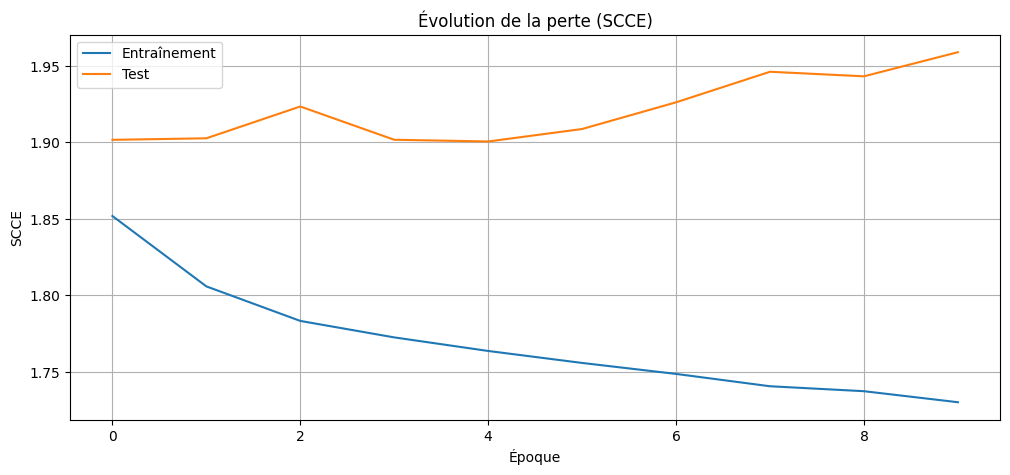

In [47]:
plt.figure(figsize=(12, 5))
plt.plot(history_TFT.history['loss'], label='Entraînement')
plt.plot(history_TFT.history['val_loss'], label='Test')
plt.title('Évolution de la perte (SCCE)')
plt.xlabel('Époque')
plt.ylabel('SCCE')
plt.legend()
plt.grid(True)
plt.show()

#### Comparaison des Répartitions Réelles et Prédites

45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step


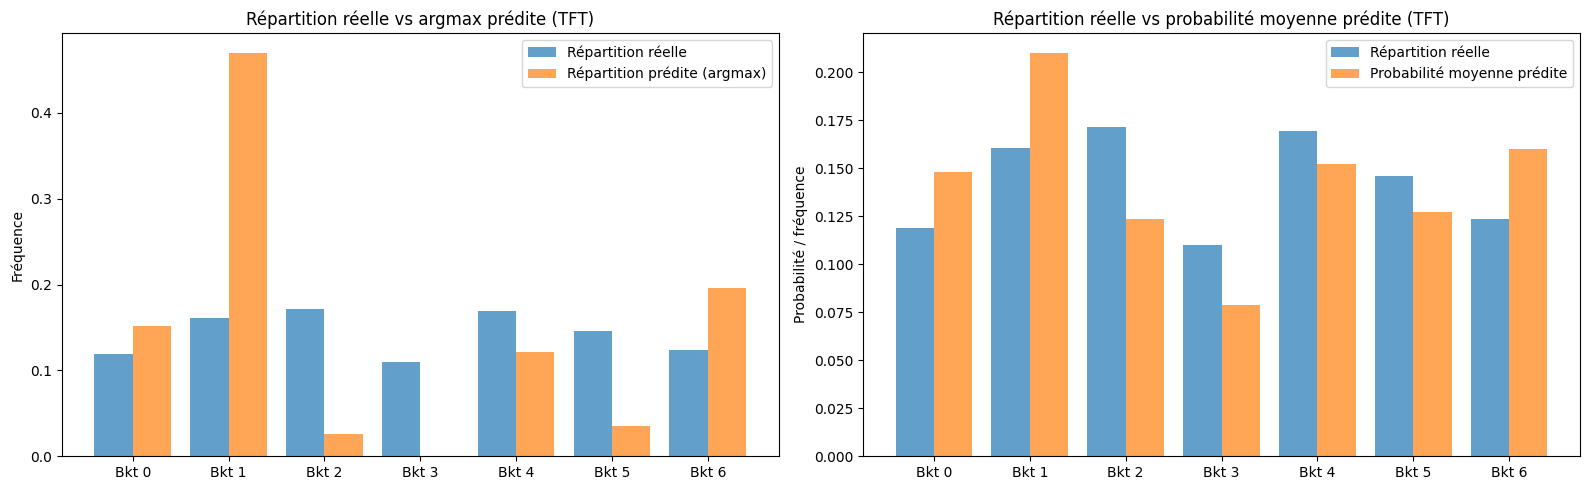

In [48]:
y_proba_TFT = model_TFT.predict(X_test_seq)
y_argmax_TFT = np.argmax(y_proba_TFT, axis=1)

true_counts = np.bincount(y_test_seq, minlength=n_buckets)
pred_counts = np.bincount(y_argmax_TFT, minlength=n_buckets)

true_freq = true_counts / true_counts.sum()
pred_freq = pred_counts / pred_counts.sum()

indices = np.arange(n_buckets)
bar_width = 0.4

mean_proba = y_proba_TFT.mean(axis=0) 

plt.figure(figsize=(16, 5))

# Graphique 1 : Répartition réelle vs Répartition prédite (argmax)
plt.subplot(1, 2, 1)
plt.bar(indices - bar_width / 2, true_freq, width=bar_width, alpha=0.7, label="Répartition réelle")
plt.bar(indices + bar_width / 2, pred_freq, width=bar_width, alpha=0.7, label="Répartition prédite (argmax)")
plt.xticks(indices, [f"Bkt {i}" for i in indices])
plt.ylabel("Fréquence")
plt.title("Répartition réelle vs argmax prédite (TFT)")
plt.legend()

# Graphique 2 : Répartition réelle vs Probabilité moyenne prédite
plt.subplot(1, 2, 2)
plt.bar(indices - bar_width / 2, true_freq, width=bar_width, alpha=0.7, label="Répartition réelle")
plt.bar(indices + bar_width / 2, mean_proba, width=bar_width, alpha=0.7, label="Probabilité moyenne prédite")
plt.xticks(indices, [f"Bkt {i}" for i in indices])
plt.ylabel("Probabilité / fréquence")
plt.title("Répartition réelle vs probabilité moyenne prédite (TFT)")
plt.legend()

plt.tight_layout()
plt.show()


### Commentaire (TFT) :

1. **Graphique 1 : Répartition réelle vs prédite (argmax)** :
   - La classe prédite dominante (par exemple, Bkt 1) est sur-représentée, ce qui peut indiquer un biais du modèle vers certaines classes.
   - Les autres buckets sont nettement sous-représentés, ce qui montre que le modèle a des difficultés à différencier correctement les catégories.

2. **Graphique 2 : Répartition réelle vs probabilité moyenne prédite** :
   - Les probabilités moyennes prédites montrent une répartition plus équilibrée, mais des écarts significatifs persistent, notamment pour les buckets sous-représentés.
   - Certaines catégories (comme Bkt 4 et Bkt 6) affichent des écarts marqués entre les fréquences réelles et les probabilités moyennes, ce qui pourrait refléter des limites dans la capacité du modèle à capturer ces classes.

#### Conclusion :
- Les performances du TFT sont influencées par des biais vers certaines classes majoritaires, ce qui affecte sa capacité à capturer une répartition plus équilibrée entre les catégories.
- Une optimisation supplémentaire des hyperparamètres ou un rééquilibrage des données d'entraînement pourrait aider à améliorer les prédictions. Comme les résultats peuvent varier selon les exécutions, une évaluation sur plusieurs runs pourrait offrir une vue plus robuste des performances globales.


### Étape 8 : Ajout d'Indices Financiers et Comparaison

#### Objectif
- Enrichir les données avec des indicateurs financiers couramment utilisés pour améliorer les performances du modèle TFT.

#### Nouveaux Indicateurs Ajoutés
1. **RSI (Relative Strength Index)** :
   - Mesure la vitesse et l'amplitude des variations de prix pour identifier les conditions de surachat ou de survente.  
     $$ RSI = 100 - \frac{100}{1 + RS} $$  
     où $RS = \frac{\text{Moyenne des gains sur } n \text{ périodes}}{\text{Moyenne des pertes sur } n \text{ périodes}}$.

2. **MACD (Moving Average Convergence Divergence)** :
   - Basé sur deux moyennes mobiles exponentielles (EMA) :  
     $$ \text{MACD} = \text{EMA}_{12} - \text{EMA}_{26} $$  
   - Une ligne de signal est ajoutée :  
     $$ \text{Signal Line} = \text{EMA}_{9}(\text{MACD}) $$

   - Formule de l'EMA :  
     $$ \text{EMA}_t = P_t \cdot \frac{2}{n+1} + \text{EMA}_{t-1} \cdot \left(1 - \frac{2}{n+1}\right) $$  
     où $P_t$ est le prix actuel, $n$ est la période, et $\text{EMA}_{t-1}$ est l'EMA précédente.

3. **Bandes de Bollinger** :
   - Mesurent la volatilité autour d'une moyenne mobile ($\text{MA}$) :  
     $$ \text{Bande Supérieure} = MA + (k \cdot \sigma) $$  
     $$ \text{Bande Inférieure} = MA - (k \cdot \sigma) $$  
     où $\sigma$ est l'écart type des prix sur une période donnée, et $k$ est un multiplicateur (souvent $k=2$).

4. **Momentum et ROC (Rate Of Change)** :
   - **Momentum** :  
     $$ \text{Momentum} = P_t - P_{t-n} $$  
     où $P_t$ est le prix actuel et $P_{t-n}$ est le prix $n$ périodes auparavant.
   - **Rate Of Change (ROC)** :  
     $$ \text{ROC} = \frac{P_t - P_{t-n}}{P_{t-n}} \times 100 $$


In [27]:
df_full = df_seq.copy()

df_full["RSI_14"] = ta.rsi(df_full["Price"], length=14)

# Ajout du MACD
macd = ta.macd(df_full["Price"])
df_full["MACD"] = macd["MACD_12_26_9"]
df_full["MACD_Signal"] = macd["MACDs_12_26_9"]
df_full["MACD_Hist"] = macd["MACDh_12_26_9"]

# Ajout des Bandes de Bollinger
bbands = ta.bbands(df_full["Price"], length=20, std=2)
df_full["BB_Lower"] = bbands["BBL_20_2.0"]
df_full["BB_Mid"] = bbands["BBM_20_2.0"]
df_full["BB_Upper"] = bbands["BBU_20_2.0"]

# Ajout du Momentum et du ROC (Rate of Change)
df_full["Momentum_5"] = ta.mom(df_full["Price"], length=5) 
df_full["ROC_5"] = ta.roc(df_full["Price"], length=5)     


df_full.dropna(inplace=True)

for col in ["RSI_14", "MACD", "MACD_Signal", "MACD_Hist", "BB_Lower", "BB_Mid", "BB_Upper", "Momentum_5", "ROC_5"]:
    df_full[col] = pd.to_numeric(df_full[col], errors='coerce')

df_full.dropna(inplace=True)


cuts_full = df_full['FutureReturn'].quantile(quantiles).values

print("quantiles:", cuts_full)

df_full['FutureReturn_bucket'] = pd.cut(
    df_full['FutureReturn'],
    bins=cuts_full,            
    labels=False,         
    include_lowest=True   
)


exclude_cols_full = ["Price", "Return", "FutureReturn", "FutureReturn_bucket"]
feature_cols_full = [c for c in df_full.columns if c not in exclude_cols_full]
X_full = df_full[feature_cols_full].values
y_full = df_full["FutureReturn_bucket"].values.astype(int)  

N_full = len(df_full)
Nt_full = int(0.8 * N_full)
Nv_full = N_full - Nt_full

X_train_full, X_test_full = X_full[:Nt_full], X_full[Nt_full:]
y_train_full, y_test_full = y_full[:Nt_full], y_full[Nt_full:]
scaler_full = StandardScaler()
X_train_scaled_full = scaler_full.fit_transform(X_train_full)
X_test_scaled_full  = scaler_full.transform(X_test_full)

seq_length = 35

X_train_seq_full, y_train_seq_full = create_sequences(X_train_scaled_full, y_train_full, seq_length)
X_test_seq_full,  y_test_seq_full  = create_sequences(X_test_scaled_full,  y_test_full,  seq_length)

print(f"Forme X_train_seq_full : {X_train_seq_full.shape}")
print(f"Forme y_train_seq_full : {y_train_seq_full.shape}")

y_train_cat_full = to_categorical(y_train_seq_full, num_classes=n_buckets)
y_test_cat_full  = to_categorical(y_test_seq_full,  num_classes=n_buckets)

loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=False) 

quantiles: [-0.19116565 -0.01851826 -0.00823029 -0.00171468  0.0020003   0.00864756
  0.0193249   0.18874477]
Forme X_train_seq_full : (5748, 35, 102)
Forme y_train_seq_full : (5748,)


### Etape 8.1 : Modèle TFT avec les features supplémentaires

In [ ]:
seq_length = 35     
n_vars = X_train_seq_full.shape[2]  
n_buckets = 7                  
batch_size = 32               

model_TFT_full = TemporalFusionTransformer(
    seq_len=seq_length,
    num_features=n_vars,  
    d_model=32,
    num_heads=4,
    dff=64,
    dropout_rate=0.1,
    n_buckets=n_buckets
)

model_TFT_full.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),  
    metrics=['accuracy']
)

history_TFT_full = model_TFT_full.fit(
    X_train_seq_full,  
    y_train_seq_full,  
    validation_data=(X_test_seq_full, y_test_seq_full),  
    epochs=10,  
    batch_size=batch_size  
)

loss_TFT_full, acc_TFT_full = model_TFT_full.evaluate(X_test_seq_full, y_test_seq_full, verbose=1)

print(f"\nTFT - Test Cross-Entropy : {loss_TFT_full:.4f}")
print(f"TFT - Test Accuracy      : {acc_TFT_full:.2%}")



Epoch 1/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 19s 43ms/step - accuracy: 0.2167 - loss: 1.9199 - val_accuracy: 0.1928 - val_loss: 1.8997
Epoch 2/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.2255 - loss: 1.8531 - val_accuracy: 0.1821 - val_loss: 1.9053
Epoch 3/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.2190 - loss: 1.8606 - val_accuracy: 0.1800 - val_loss: 1.8867
Epoch 4/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.2332 - loss: 1.8099 - val_accuracy: 0.1729 - val_loss: 1.8905
Epoch 5/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - accuracy: 0.2399 - loss: 1.8043 - val_accuracy: 0.1793 - val_loss: 1.8900
Epoch 6/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.2387 - loss: 1.7966 - val_accuracy: 0.1736 - val_loss: 1.8927
Epoch 7/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.2371 - loss: 1.7947 - val_accuracy: 0.1786 - val_loss: 1.8896
Epoch 8/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.2505 - loss: 1.7880 - val_ac

45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step


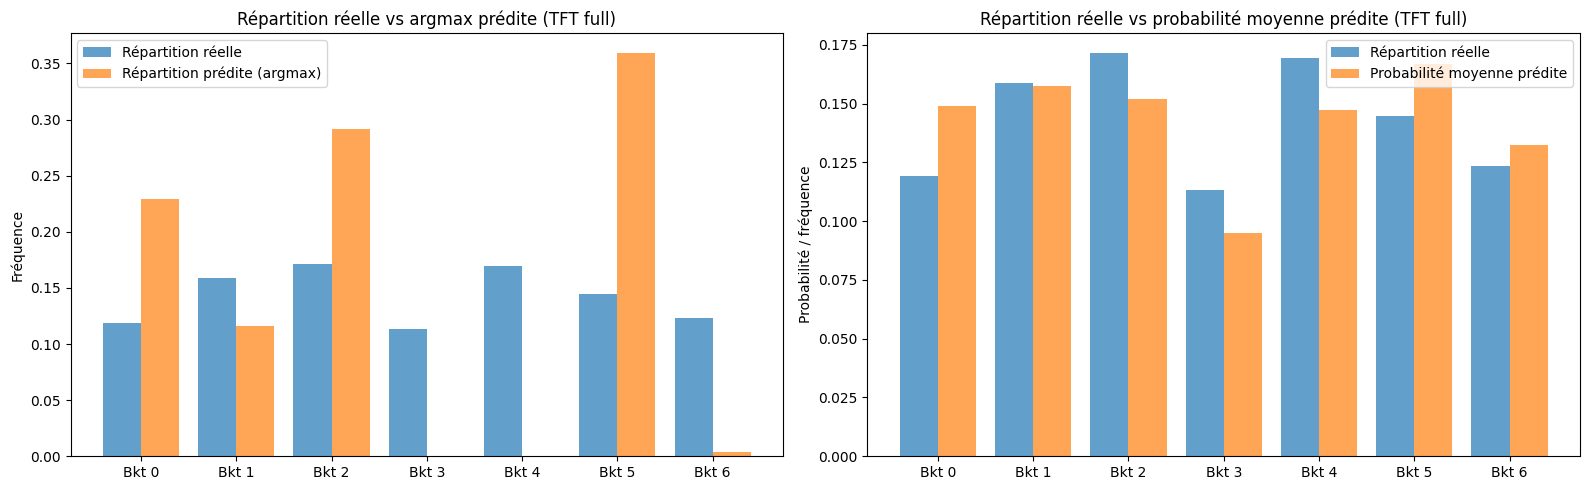

In [29]:
y_proba_TFT_full = model_TFT_full.predict(X_test_seq_full)
y_argmax_TFT_full = np.argmax(y_proba_TFT_full, axis=1)

true_counts = np.bincount(y_test_seq_full, minlength=n_buckets)
pred_counts = np.bincount(y_argmax_TFT_full, minlength=n_buckets)

true_freq = true_counts / true_counts.sum()
pred_freq = pred_counts / pred_counts.sum()

indices = np.arange(n_buckets)
bar_width = 0.4

mean_proba = y_proba_TFT_full.mean(axis=0)  

plt.figure(figsize=(16, 5))

# Graphique 1 : Répartition réelle vs Répartition prédite (argmax)
plt.subplot(1, 2, 1)
plt.bar(indices - bar_width / 2, true_freq, width=bar_width, alpha=0.7, label="Répartition réelle")
plt.bar(indices + bar_width / 2, pred_freq, width=bar_width, alpha=0.7, label="Répartition prédite (argmax)")
plt.xticks(indices, [f"Bkt {i}" for i in indices])
plt.ylabel("Fréquence")
plt.title("Répartition réelle vs argmax prédite (TFT full)")
plt.legend()

# Graphique 2 : Répartition réelle vs Probabilité moyenne prédite
plt.subplot(1, 2, 2)
plt.bar(indices - bar_width / 2, true_freq, width=bar_width, alpha=0.7, label="Répartition réelle")
plt.bar(indices + bar_width / 2, mean_proba, width=bar_width, alpha=0.7, label="Probabilité moyenne prédite")
plt.xticks(indices, [f"Bkt {i}" for i in indices])
plt.ylabel("Probabilité / fréquence")
plt.title("Répartition réelle vs probabilité moyenne prédite (TFT full)")
plt.legend()

plt.tight_layout()
plt.show()


### Commentaire

Les résultats obtenus avec le modèle **TFT full** montrent une meilleure généralisation par rapport aux versions précédentes. 

- **Graphique 1** : La répartition prédite ($\text{argmax}$) est plus proche de la répartition réelle, bien que certaines classes, comme Bkt 2 et Bkt 5, restent sur-représentées.
- **Graphique 2** : Les probabilités moyennes prédites sont globalement mieux alignées avec les fréquences réelles, indiquant une meilleure capture des tendances globales.

Ces améliorations suggèrent que l'ajout des indicateurs financiers contribue positivement à la capacité du modèle à généraliser.


### Etape 8.2 : Modèle LSTM avec les features supplémentaire

In [31]:
model_lstm_full = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(seq_length, X_train_seq_full.shape[2])),
    tf.keras.layers.LSTM(128, return_sequences=True, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.LSTM(64, return_sequences=False, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(n_buckets, activation='softmax')  
])

model_lstm_full.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


history_lstm_full = model_lstm_full.fit(
    X_train_seq_full, y_train_seq_full,
    validation_data=(X_test_seq_full, y_test_seq_full),
    epochs=10,
    batch_size=32,
    verbose=1
)

loss_lstm_full, acc_lstm_full = model_lstm_full.evaluate(X_test_seq_full, y_test_seq_full, verbose=0)
print(f"\nTest loss (cross-entropy) : {loss_lstm_full:.4f}")
print(f"Test accuracy             : {acc_lstm_full:.2%}")


Epoch 1/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 22s 87ms/step - accuracy: 0.2063 - loss: 1.9520 - val_accuracy: 0.1899 - val_loss: 1.9214
Epoch 2/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 14s 76ms/step - accuracy: 0.2366 - loss: 1.8694 - val_accuracy: 0.1956 - val_loss: 1.9518
Epoch 3/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 15s 80ms/step - accuracy: 0.2472 - loss: 1.8661 - val_accuracy: 0.1616 - val_loss: 1.9126
Epoch 4/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 20s 75ms/step - accuracy: 0.2399 - loss: 1.8352 - val_accuracy: 0.1871 - val_loss: 1.9169
Epoch 5/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 14s 78ms/step - accuracy: 0.2483 - loss: 1.8263 - val_accuracy: 0.1942 - val_loss: 1.9059
Epoch 6/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 17s 91ms/step - accuracy: 0.2490 - loss: 1.8159 - val_accuracy: 0.1673 - val_loss: 1.9597
Epoch 7/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 15s 80ms/step - accuracy: 0.2500 - loss: 1.8166 - val_accuracy: 0.2069 - val_loss: 1.8992
Epoch 8/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 15s 81ms/step - accuracy: 0.2480 - loss: 1.8188 - 

45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step


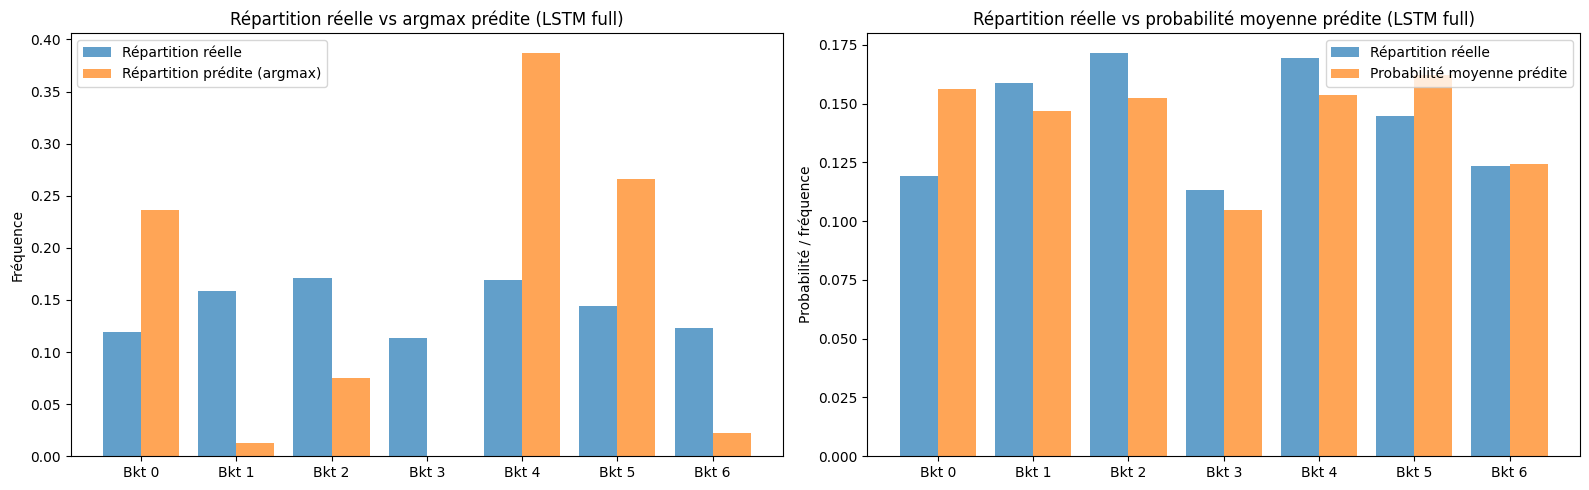

In [32]:
y_proba_lstm_full = model_lstm_full.predict(X_test_seq_full)
y_argmax_lstm_full = np.argmax(y_proba_lstm_full, axis=1)

true_counts = np.bincount(y_test_seq_full, minlength=n_buckets)
pred_counts = np.bincount(y_argmax_lstm_full, minlength=n_buckets)

true_freq = true_counts / true_counts.sum()
pred_freq = pred_counts / pred_counts.sum()

indices = np.arange(n_buckets)
bar_width = 0.4

mean_proba = y_proba_lstm_full.mean(axis=0)  

plt.figure(figsize=(16, 5))

# Graphique 1 : Répartition réelle vs Répartition prédite (argmax)
plt.subplot(1, 2, 1)
plt.bar(indices - bar_width / 2, true_freq, width=bar_width, alpha=0.7, label="Répartition réelle")
plt.bar(indices + bar_width / 2, pred_freq, width=bar_width, alpha=0.7, label="Répartition prédite (argmax)")
plt.xticks(indices, [f"Bkt {i}" for i in indices])
plt.ylabel("Fréquence")
plt.title("Répartition réelle vs argmax prédite (LSTM full)")
plt.legend()

# Graphique 2 : Répartition réelle vs Probabilité moyenne prédite
plt.subplot(1, 2, 2)
plt.bar(indices - bar_width / 2, true_freq, width=bar_width, alpha=0.7, label="Répartition réelle")
plt.bar(indices + bar_width / 2, mean_proba, width=bar_width, alpha=0.7, label="Probabilité moyenne prédite")
plt.xticks(indices, [f"Bkt {i}" for i in indices])
plt.ylabel("Probabilité / fréquence")
plt.title("Répartition réelle vs probabilité moyenne prédite (LSTM full)")
plt.legend()

plt.tight_layout()
plt.show()

### Commentaire

Les résultats obtenus avec le modèle **LSTM full** montrent également une amélioration dans la généralisation.

- **Graphique 1** : La répartition prédite ($\text{argmax}$) est plus alignée avec la répartition réelle, bien que certaines classes, comme Bkt 4 et Bkt 5, restent sur-représentées.
- **Graphique 2** : Les probabilités moyennes prédites sont globalement cohérentes avec les fréquences réelles, indiquant une capacité améliorée à capturer les tendances des données.

Ces observations suggèrent que l'ajout des indicateurs financiers aide le modèle LSTM à mieux généraliser, même si quelques déséquilibres persistent.

In [45]:

bucket_kdes = {}

for b in sorted(df_seq['FutureReturn_bucket'].unique()):
    subset = df_seq.loc[df_seq['FutureReturn_bucket'] == b, 'FutureReturn']
    
    # Fit KDE
    kde = gaussian_kde(subset)
    bucket_kdes[b] = kde
    
    print(f"Bucket {b}: Estimated bandwidth = {kde.factor:.3f} (depends on subset)")


Bucket 0: Estimated bandwidth = 0.263 (depends on subset)
Bucket 1: Estimated bandwidth = 0.263 (depends on subset)
Bucket 2: Estimated bandwidth = 0.263 (depends on subset)
Bucket 3: Estimated bandwidth = 0.263 (depends on subset)
Bucket 4: Estimated bandwidth = 0.263 (depends on subset)
Bucket 5: Estimated bandwidth = 0.263 (depends on subset)
Bucket 6: Estimated bandwidth = 0.263 (depends on subset)


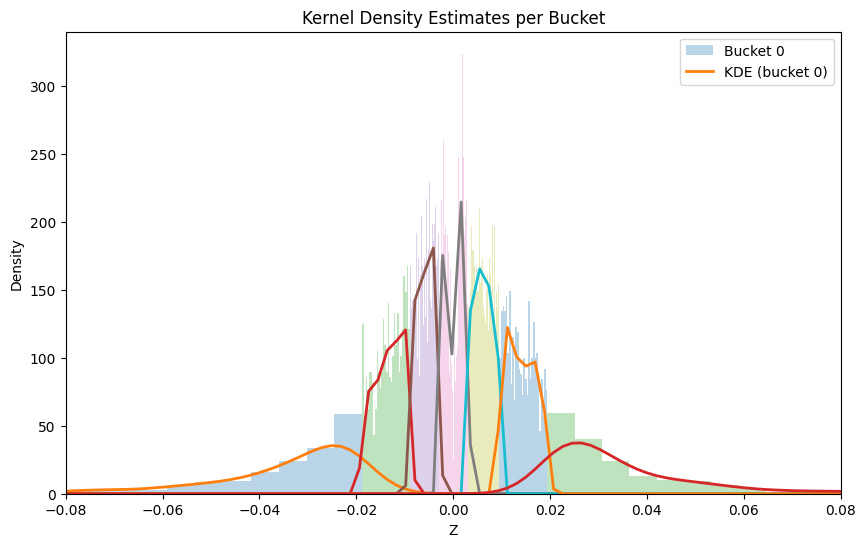

In [46]:
x_vals = np.linspace(df_seq['FutureReturn'].min(), df_seq['FutureReturn'].max(), 200)

plt.figure(figsize=(10, 6))
for b in sorted(df_seq['FutureReturn_bucket'].unique()):
    subset = df_seq.loc[df_seq['FutureReturn_bucket'] == b, 'FutureReturn']
    kde = bucket_kdes[b]
    
    # Empirical histogram for the subset
    plt.hist(subset, bins=30, alpha=0.3, density=True, 
             label=f"Bucket {b}" if b == 0 else "")
    
    # Plot the kernel density
    pdf_vals = kde(x_vals)
    plt.plot(x_vals, pdf_vals, lw=2, 
             label=f"KDE (bucket {b})" if b == 0 else "")
    plt.xlim(-0.08,0.08)
    
plt.title("Kernel Density Estimates per Bucket")
plt.xlabel("Z")
plt.ylabel("Density")
plt.legend()
plt.show()


In [56]:
prob_pred_buckets = model_lstm.predict(X_test_seq) 

generated_Z_prob = []

for p in prob_pred_buckets:  
    generated_samples = np.array([bucket_kdes[b].resample(1)[0][0] for b in range(n_buckets)])
    z_draw = np.sum(p * generated_samples)
    generated_Z_prob.append(z_draw)

generated_Z_prob = np.array(generated_Z_prob)


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


In [57]:
fig_rf = go.Figure()

# Ajout des vrais rendements
fig_rf.add_trace(go.Scatter(
    x=list(range(len(y_test))),
    y=y_test,
    mode='lines+markers',
    name='Vrais rendements (Réels)',
    line=dict(color='blue', dash='solid'),
    marker=dict(symbol='circle', size=6),
    opacity=0.7
))

# Ajout des prédictions LSTM
fig_rf.add_trace(go.Scatter(
    x=list(range(len(generated_Z_prob))),
    y=generated_Z_prob,
    mode='lines+markers',
    name='Prédictions (LSTM)',
    line=dict(color='red', dash='dash'),
    marker=dict(symbol='x', size=6),
    opacity=0.7
))

# Mise à jour de la mise en page
fig_rf.update_layout(
    title="Comparaison des Vrais Rendements et des Prédictions (LSTM)",
    xaxis=dict(
        title="Index Chronologique",
        showgrid=True,
        zeroline=True
    ),
    yaxis=dict(
        title="Rendement",
        showgrid=True,
        zeroline=True
    ),
    legend=dict(
        font=dict(size=12),
        bgcolor="rgba(255,255,255,0.5)",
        bordercolor="rgba(0,0,0,0.1)",
        borderwidth=1
    ),
    template="plotly_white"
)